# **US Accidents Analysis and Visualization**
This notebook focuses on exploring and visualizing the US accidents dataset. The steps include data preprocessing, cleaning, and generating insightful visualizations.


**Team Members**

Buğra Burak Başer, Melike Beria Ayas, Abdullah Salih Öner


## **1. Importing Libraries**
We start by importing necessary libraries for data analysis and visualization.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from pandasql import sqldf
import warnings
import geopandas as gpd

import plotly.graph_objects as go
from nltk.corpus import stopwords



# Configure plots for better readability
sns.set_theme(style="darkgrid", palette="muted", font_scale=1.1)



## **2. Loading the Dataset**
The dataset contains traffic accident records from the United States (2016-2019). We load the data and inspect its structure.


In [2]:
# Path to dataset
data_path = "/kaggle/input/us-accidents/US_Accidents_March23.csv"

# Load dataset
df = pd.read_csv(data_path)

# Display basic information
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns)
df.head()


Dataset Shape: (7728394, 46)
Dataset Columns: Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


## **3. Checking for Missing Data**
We identify columns with missing values and address them appropriately during preprocessing.


In [3]:
# Check missing values
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]  # Only display columns with missing data
print("Columns with Missing Values:\n", missing_data)

Columns with Missing Values:
 End_Lat                  3402762
End_Lng                  3402762
Precipitation(in)        2203586
Wind_Chill(F)            1999019
Wind_Speed(mph)           571233
Visibility(mi)            177098
Wind_Direction            175206
Humidity(%)               174144
Weather_Condition         173459
Temperature(F)            163853
Pressure(in)              140679
Weather_Timestamp         120228
Nautical_Twilight          23246
Civil_Twilight             23246
Sunrise_Sunset             23246
Astronomical_Twilight      23246
Airport_Code               22635
Street                     10869
Timezone                    7808
Zipcode                     1915
City                         253
Description                    5
dtype: int64


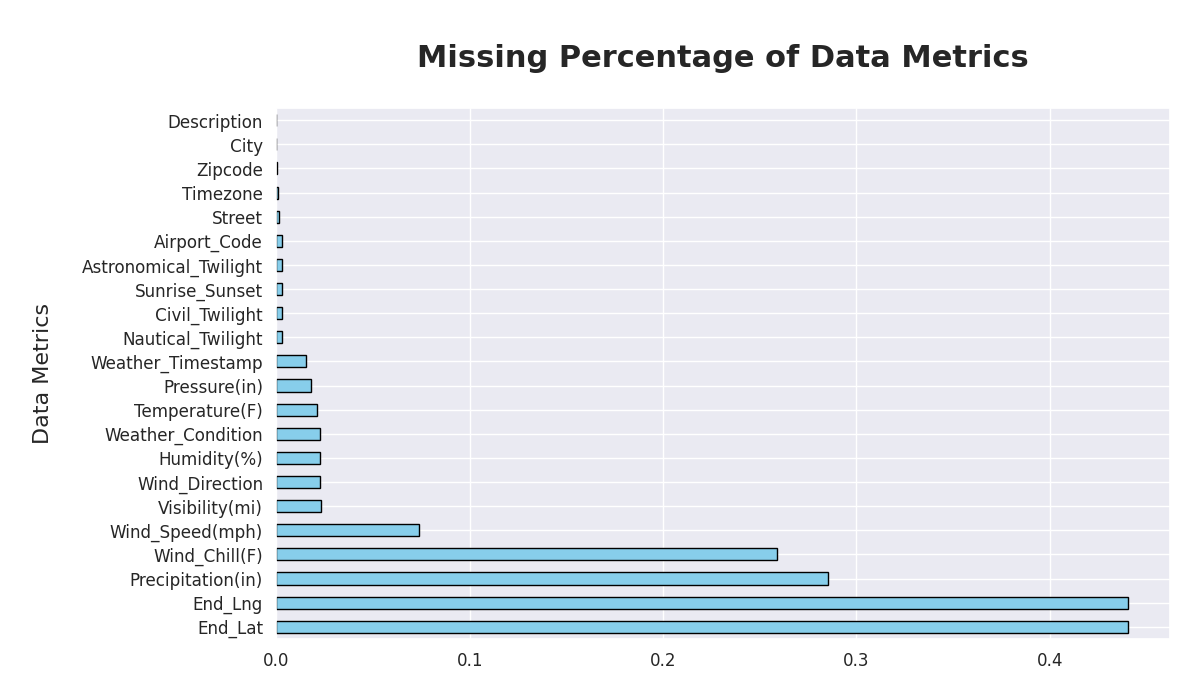

In [4]:
# Visualization for Missing Data
plt.figure(figsize=(12, 7))  
plt.title('\nMissing Percentage of Data Metrics\n', fontsize=22, fontweight='bold') 
plt.ylabel('\nData Metrics\n', fontsize=16)  
plt.xlabel('\nMissing Percentage\n', fontsize=16) 

missing_percentage = df.isna().sum().sort_values(ascending=False) / len(df)
missing_percentage[missing_percentage != 0].plot(kind='barh', color='skyblue', edgecolor='black')

plt.tight_layout()
plt.show()


The dataset contains missing values in several columns, especially **`End_Lat`** and **`End_Lng`**. Those columns will be dropped. Weather-related columns like **`Precipitation(in)`** and **`Wind_Chill(F)`** will be filled with their **median** values. Categorical columns like **`Sunrise_Sunset`**, **`Weather_Condition`** will be filled with the **mode**. Minor missing values in columns like **`Description`** and **`City`** will be fixed by dropping affected rows.

## **4. Handling Missing Values and Transforming Date Time Columns**
### 4.1 Handling Missing Values
- Fill missing numerical values with median value
- Fill missing categorical rows with mode
.
- Drop rows with critical missing data.


In [5]:
# Dropping columns with excessive missing values
df.drop(columns=['End_Lat', 'End_Lng'], inplace=True)

# Filling missing weather-related columns with the median
weather_cols = ['Precipitation(in)', 'Wind_Chill(F)', 'Wind_Speed(mph)', 
                'Visibility(mi)', 'Temperature(F)', 'Pressure(in)', 'Humidity(%)']
for col in weather_cols:
    df[col] = df[col].fillna(df[col].median())  # Direct assignment without inplace=True

# Filling categorical columns with mode
categorical_cols = ['Weather_Condition', 'Wind_Direction', 
                    'Sunrise_Sunset', 'Civil_Twilight', 
                    'Nautical_Twilight', 'Astronomical_Twilight']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # Direct assignment without inplace=True

# Dropping rows with critical missing data (e.g., 'Description', 'City')
df.dropna(subset=['Description', 'City'], inplace=True)

# Verify if missing values are addressed
print("Remaining Missing Values:\n", df.isnull().sum().sum())


Remaining Missing Values:
 163445


In [6]:
remaining_missing = df.isnull().sum()
print(remaining_missing[remaining_missing > 0])


Street                10869
Zipcode                1913
Timezone               7806
Airport_Code          22633
Weather_Timestamp    120224
dtype: int64


Rows with missing `Zipcode` were dropped, and the `Street` column was removed. Missing `Timezone` values were filled with the mode, while `Airport_Code` and `Weather_Timestamp` were dropped for simplicity, resulting in a cleaner dataset.












In [7]:
# Drop rows where Zipcode is missing
df = df[df['Zipcode'].notna()]

# Drop the Street column
df = df.drop(columns=['Street'])

# Fill missing Timezone values with the mode
timezone_mode = df['Timezone'].mode()[0]
df.loc[:, 'Timezone'] = df['Timezone'].fillna(timezone_mode)

# Drop Airport_Code and Weather_Timestamp columns
df = df.drop(columns=['Airport_Code', 'Weather_Timestamp'])

# Verify the remaining missing values
print("Remaining Missing Values After Cleanup:\n", df.isnull().sum().sum())

Remaining Missing Values After Cleanup:
 0


### 4.2 Transforming Date-Time Columns
Extract useful features such as `Year`, `Month`, `Day`, and `Hour` from the `Start_Time` column for analysis.


In [8]:
# Convert Start_Time and End_Time to datetime, handling invalid formats
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Check for rows with NaT (invalid dates)
invalid_dates = df[df['Start_Time'].isna() | df['End_Time'].isna()]
print(f"Number of invalid Start_Time or End_Time entries: {len(invalid_dates)}")

# Drop rows with invalid Start_Time or End_Time
df = df.dropna(subset=['Start_Time', 'End_Time'])

# Extract features from Start_Time
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour

# Optional: Verify the newly created columns
print(df[['Start_Time', 'Year', 'Month', 'Day', 'Hour']].head())


Number of invalid Start_Time or End_Time entries: 742903
           Start_Time  Year  Month  Day  Hour
0 2016-02-08 05:46:00  2016      2    8     5
1 2016-02-08 06:07:59  2016      2    8     6
2 2016-02-08 06:49:27  2016      2    8     6
3 2016-02-08 07:23:34  2016      2    8     7
4 2016-02-08 07:39:07  2016      2    8     7


## **5. Exploratory Data Analysis**### 5.1  Accidents by Year
Visualizing the number of accidents recorded in each year.


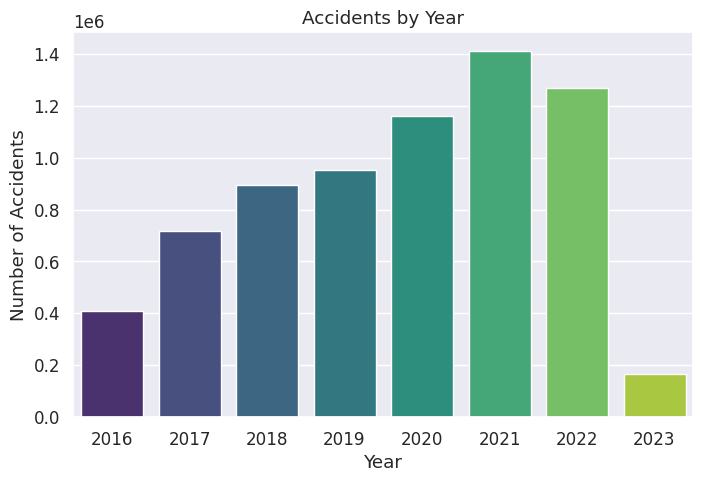

In [9]:
# Plot accidents by year
plt.figure(figsize=(8, 5))
sns.countplot(x='Year', data=df, palette='viridis')
plt.title("Accidents by Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.show()


The yearly distribution highlights a general increase in accidents over time, but this trend may primarily reflect reporting patterns or data collection improvements rather than actual changes in accident frequency. Therefore, **year-based trends might not provide significant insights** for understanding accident causes or severity.

### 5.2 Hourly Accident Distributionon
Analyzing at what time of the day most accidents occur.


In [10]:
# Check if there are any infinite, NaN or non-numeric values in the Hour column

print("Infinite values in 'Hour':", np.isinf(df['Hour']).sum())
print("NaN values in 'Hour':", df['Hour'].isna().sum())
print("Non-numeric values in 'Hour':", df['Hour'].apply(lambda x: not isinstance(x, (int, float))).sum())


Infinite values in 'Hour': 0
NaN values in 'Hour': 0
Non-numeric values in 'Hour': 0



Since the `Hour` column has **no infinite, NaN,** or **non-numeric** values, the data is clean.

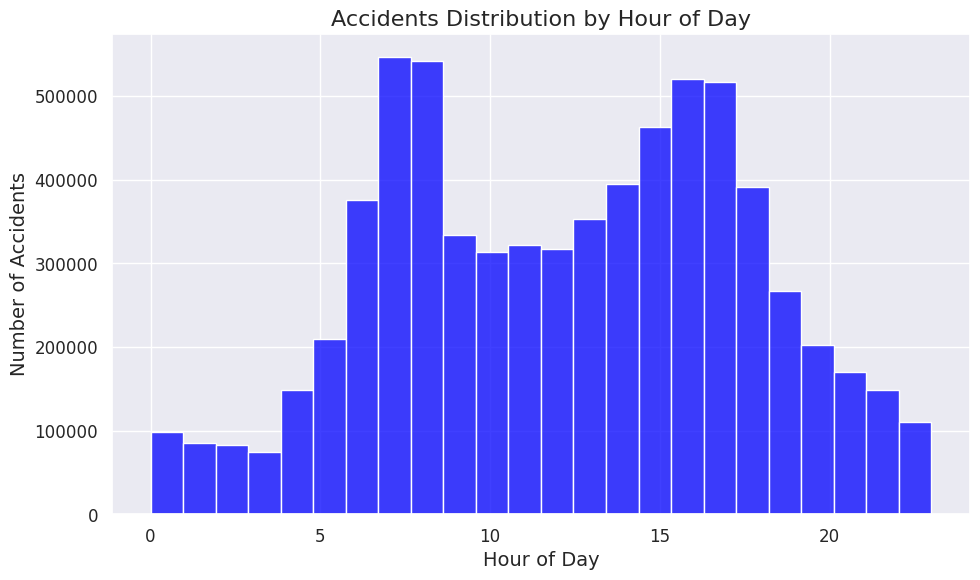

In [11]:


# As we know that the data is clean, we can ignore the errors that possibly occured because of the version difference.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Plot the hourly accident distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Hour'], bins=24, kde=False, color='blue')
    plt.title("Accidents Distribution by Hour of Day", fontsize=16)
    plt.xlabel("Hour of Day", fontsize=14)
    plt.ylabel("Number of Accidents", fontsize=14)
    plt.tight_layout()
    plt.show()


This histogram reveals a clear pattern in the hourly distribution of accidents. Peaks occur during **morning rush hours (6-9 AM)** and **evening rush hours (3-6 PM)**, likely due to increased traffic during commuting times. The distribution highlights the importance of targeted safety measures during these periods.







### **5.3 Number of Cases by City**
This visualization shows the top 20 cities with the highest number of traffic accidents. It provides insights into which urban areas are most affected by accidents, helping identify potential hotspots for traffic safety improvements.


In [12]:
# Check how many unique cities are in the dataset
unique_cities = df['City'].nunique()
unique_cities

13557

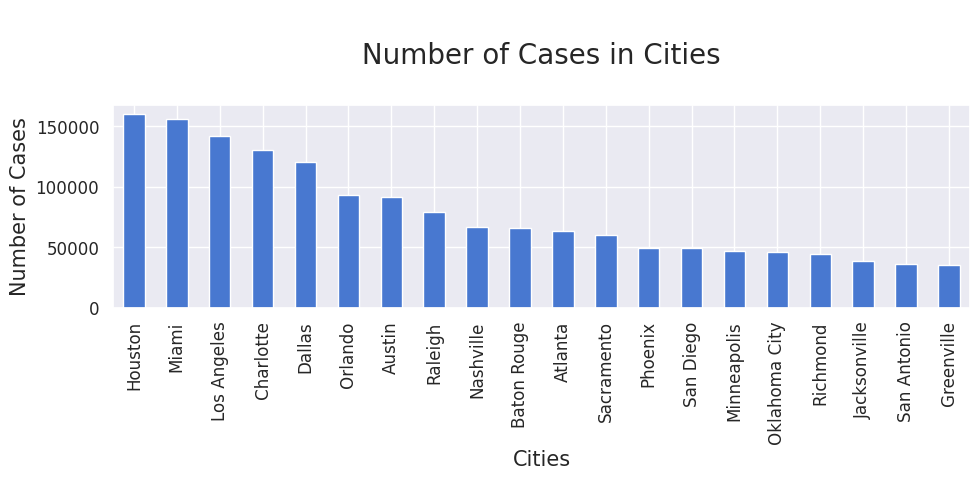

In [13]:
# Top 20 cities with the highest number of accidents
cities_accidents = df.City.value_counts()

ax = cities_accidents[:20].plot(kind='bar', title='\n Number of Cases in Cities \n', figsize=(10, 5))
ax.title.set_size(20) 
ax.set_xlabel("Cities", fontdict={'fontsize': 15}) 
ax.set_ylabel("Number of Cases", fontdict={'fontsize': 15}) 
plt.tight_layout()
plt.show()


This bar chart highlights the top cities with the highest number of accidents, with **Houston, Miami, and Los Angeles** leading. These cities may experience high traffic volumes or risk factors contributing to accidents, making them key areas for traffic safety interventions.


### **5.4 Distribution of Accidents by Temperature**
This visualization illustrates the distribution of accidents based on temperature (`Temperature(F)`). The density plot provides insights into how temperature variations might correlate with accident occurrences.


In [14]:
# Check if there are any infinite, NaN, or non-numeric values in the 'Temperature(F)' column

print("Infinite values in 'Temperature(F)':", np.isinf(df['Temperature(F)']).sum())
print("NaN values in 'Temperature(F)':", df['Temperature(F)'].isna().sum())
print("Non-numeric values in 'Temperature(F)':", df['Temperature(F)'].apply(lambda x: not isinstance(x, (int, float))).sum())


Infinite values in 'Temperature(F)': 0
NaN values in 'Temperature(F)': 0
Non-numeric values in 'Temperature(F)': 0


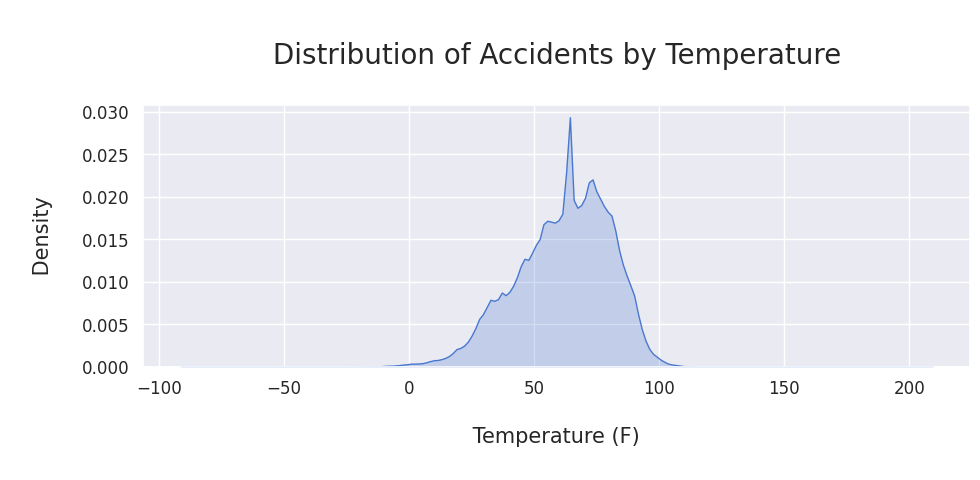

In [15]:
# As we know that the data is clean, we can ignore the errors that possibly occured because of the version difference.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Filter valid data for Temperature(F)
    plt.figure(figsize=(10, 5))
    plt.title('\n Distribution of Accidents by Temperature \n', size=20)
    plt.ylabel('\n Density \n', fontsize=15)
    plt.xlabel('\n Temperature (F) \n', fontsize=15)
    sns.kdeplot(data=df['Temperature(F)'], fill=True)
    plt.tight_layout()
    plt.show()


The distribution shows that most accidents occur in moderate temperatures, primarily between **30°F and 70°F**, with a peak around **50°F**. This trend suggests that moderate weather conditions, which are more common in populated areas, see the highest traffic activity. Accidents are less frequent in extreme temperatures, likely due to reduced travel or increased caution during harsh weather conditions.

### **5.5 Distribution of Accidents by Visibility**
This visualization highlights the distribution of accidents based on visibility conditions (`Visibility(mi)`). The density plot provides insights into how visibility levels might influence accident occurrences.


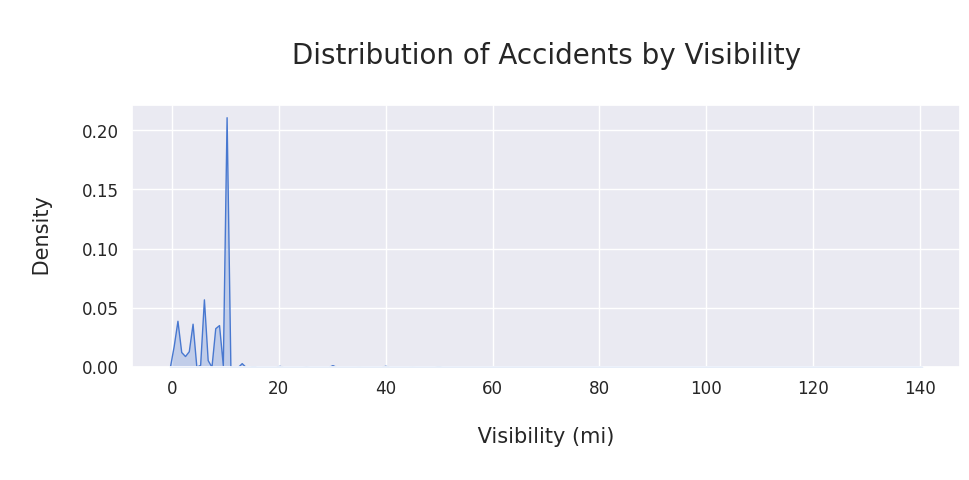

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plot: Distribution of Accidents by Visibility
    plt.figure(figsize=(10, 5))
    plt.title('\n Distribution of Accidents by Visibility \n', size=20)
    plt.ylabel('\n Density \n', fontsize=15)
    plt.xlabel('\n Visibility (mi) \n', fontsize=15)
    sns.kdeplot(data=df["Visibility(mi)"], fill=True)  # Replace shade=True with fill=True
    plt.tight_layout()
    plt.show()

The distribution indicates that **most accidents occur under low visibility conditions**, particularly between 0-10 miles, likely due to weather-related hazards like fog, rain, or snow. Accidents decrease significantly as visibility improves beyond 10 miles. The presence of outliers with extremely high visibility values suggests potential data anomalies or rare cases, which may warrant further investigation.

### **5.6 Distribution of Accidents by Wind Speed**
This visualization shows the distribution of accidents based on wind speed (`Wind_Speed(mph)`). The density plot offers insights into how variations in wind speed correlate with accident occurrences.


In [17]:
# Check if there are any infinite, NaN, or non-numeric values in the 'Wind_Speed(mph)' column

print("Infinite values in 'Wind_Speed(mph)':", np.isinf(df['Wind_Speed(mph)']).sum())
print("NaN values in 'Wind_Speed(mph)':", df['Wind_Speed(mph)'].isna().sum())
print("Non-numeric values in 'Wind_Speed(mph)':", df['Wind_Speed(mph)'].apply(lambda x: not isinstance(x, (int, float))).sum())


Infinite values in 'Wind_Speed(mph)': 0
NaN values in 'Wind_Speed(mph)': 0
Non-numeric values in 'Wind_Speed(mph)': 0


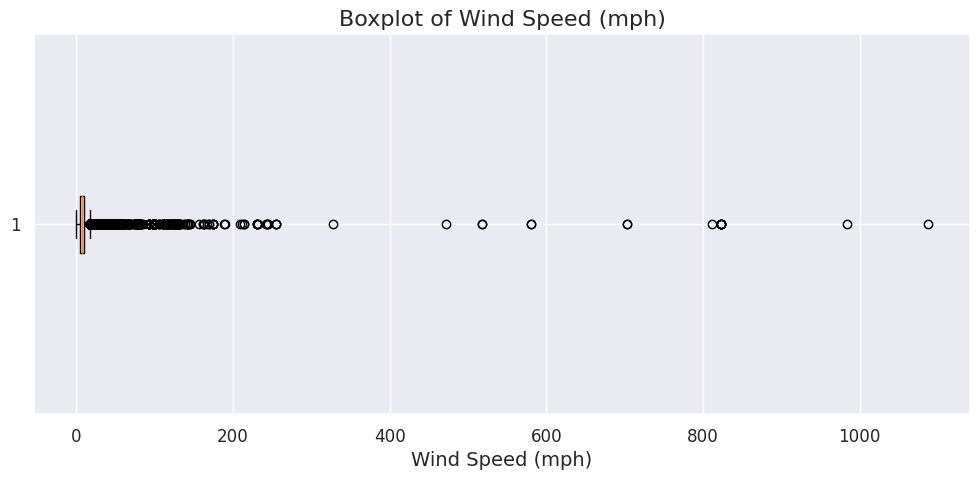

In [18]:
# Plot a boxplot to check for outliers in 'Wind_Speed(mph)'
plt.figure(figsize=(10, 5))
plt.title("Boxplot of Wind Speed (mph)", fontsize=16)
plt.xlabel("Wind Speed (mph)", fontsize=14)
plt.boxplot(df['Wind_Speed(mph)'], vert=False) 
plt.tight_layout()
plt.show()

In [19]:
# Calculate the IQR and thresholds for outliers in 'Wind_Speed(mph)'
Q1 = df['Wind_Speed(mph)'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df['Wind_Speed(mph)'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile Range

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)


Lower Bound: -2.5
Upper Bound: 17.5


Lower Bound for a wind speed cannot be negative thats why we set 0.

In [20]:
# Correct the lower bound to 0 (minimum valid wind speed)
lower_bound = 0

In [21]:
# Filter the dataset based on the corrected bounds
df_cleaned = df[(df['Wind_Speed(mph)'] >= lower_bound) & (df['Wind_Speed(mph)'] <= upper_bound)]

# Verify the updated column
print("Cleaned 'Wind_Speed(mph)' statistics:")
print(df_cleaned['Wind_Speed(mph)'].describe())

Cleaned 'Wind_Speed(mph)' statistics:
count    6.723566e+06
mean     7.105179e+00
std      4.250687e+00
min      0.000000e+00
25%      4.600000e+00
50%      7.000000e+00
75%      9.200000e+00
max      1.730000e+01
Name: Wind_Speed(mph), dtype: float64


In [22]:
# Calculate the number of rows dropped
rows_dropped = len(df) - len(df_cleaned)
print("Number of rows dropped:", rows_dropped)

Number of rows dropped: 259754


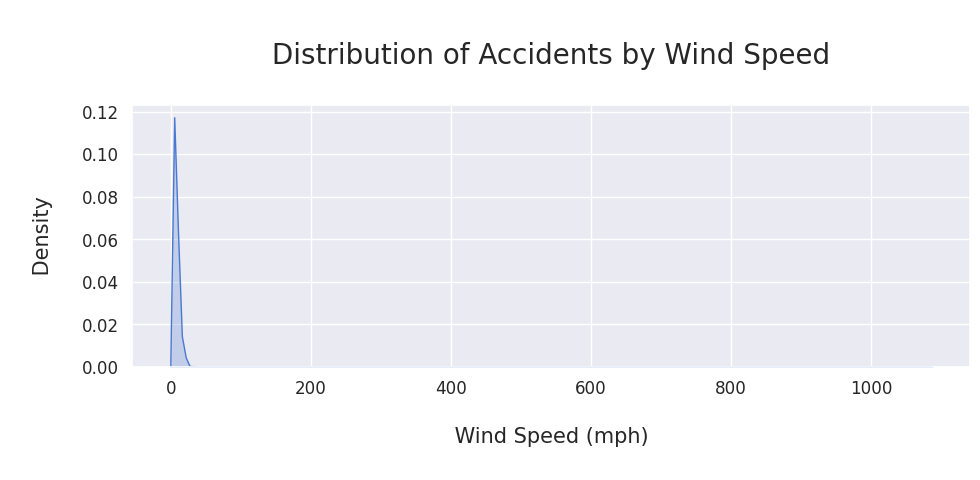

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plot: Distribution of Accidents by Wind Speed
    plt.figure(figsize=(10, 5))
    plt.title('\n Distribution of Accidents by Wind Speed \n', size=20)
    plt.ylabel('\n Density \n', fontsize=15)
    plt.xlabel('\n Wind Speed (mph) \n', fontsize=15)
    sns.kdeplot(data=df["Wind_Speed(mph)"], fill=True)  # Replace shade=True with fill=True
    plt.tight_layout()
    plt.show()

The distribution shows that most accidents occur under low wind speed conditions, primarily below 20 mph, with a sharp peak near zero wind speed. This suggests that wind speed has minimal direct impact on the majority of accidents. However, the presence of outliers with extreme wind speeds (above 200 mph) may indicate erroneous data entries or rare, severe weather conditions like hurricanes or tornadoes. Cleaning the data to focus on realistic wind speeds could improve the clarity of this analysis.


### **5.7 Distribution of Cases by Severity**
This pie chart visualizes the proportion of traffic accidents across different severity levels (`Severity`). It helps to understand how accidents are distributed by their impact.


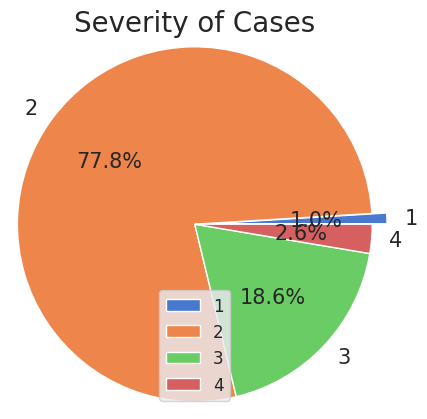

In [24]:
# Count accidents grouped by severity using pandas
severity_pie = df.groupby("Severity").size()

# Labels for severity levels
mylabels = severity_pie.index.astype(str)

# Plot the pie chart
plt.title("Severity of Cases", fontsize=20)
plt.pie(
    severity_pie,
    labels=mylabels,
    autopct='%1.1f%%',
    textprops={'fontsize': 15},
    radius=1.2,
    explode=(0.1, 0, 0, 0)  # Slightly emphasize the first segment
)
plt.legend(mylabels, loc="best")
plt.show()


The pie chart reveals that the majority of traffic accidents (77.8%) fall under severity level **2**, indicating moderately severe incidents. Severity level **3** accounts for 18.6% of accidents, representing more serious cases. Levels **1** and **4** together contribute to less than 4% of cases, highlighting that extremely minor or severe accidents are relatively rare. This distribution suggests a focus on mitigating moderately severe accidents could yield significant safety improvements.







### **5.8 Temperature Distribution by Severity**

This visualization shows the distribution of reported temperatures (`Temperature(F)`) during accidents, grouped by severity levels. It highlights how different severities might correlate with temperature conditions.


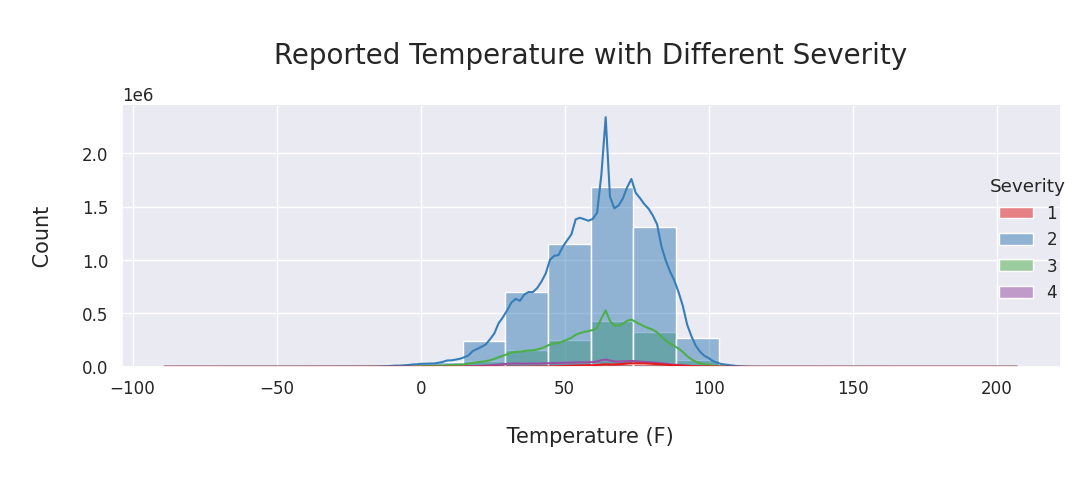

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Plot: Temperature Distribution by Severity
    sns.displot(
        df, 
        x="Temperature(F)", 
        hue="Severity", 
        palette="Set1", 
        height=5, 
        aspect=2, 
        bins=20, 
        kde=True
    )

    # Add title and labels
    plt.title('\n Reported Temperature with Different Severity \n', size=20)
    plt.ylabel('\n Count \n', fontsize=15)
    plt.xlabel('\n Temperature (F) \n', fontsize=15)

    # Display the plot
    plt.tight_layout()
    plt.show()

This visualization highlights the distribution of accidents across temperature ranges, grouped by severity levels. The majority of accidents occur at moderate temperatures between **30°F and 70°F**, with severity level **2** dominating, as expected from previous analyses. Severity levels **3** and **4** are more evenly distributed within this range, but they remain relatively infrequent compared to level **2**. The presence of very low and high temperatures (e.g., below 0°F or above 100°F) is rare, likely due to less frequent driving in extreme weather conditions. This distribution suggests that temperature alone may not strongly influence the severity of accidents.

### **5.9 Wind Direction Impact on Severity**


This bar chart visualizes the proportion of accidents by wind direction, grouped by severity levels. It highlights whether wind direction has a significant influence on accident severity.


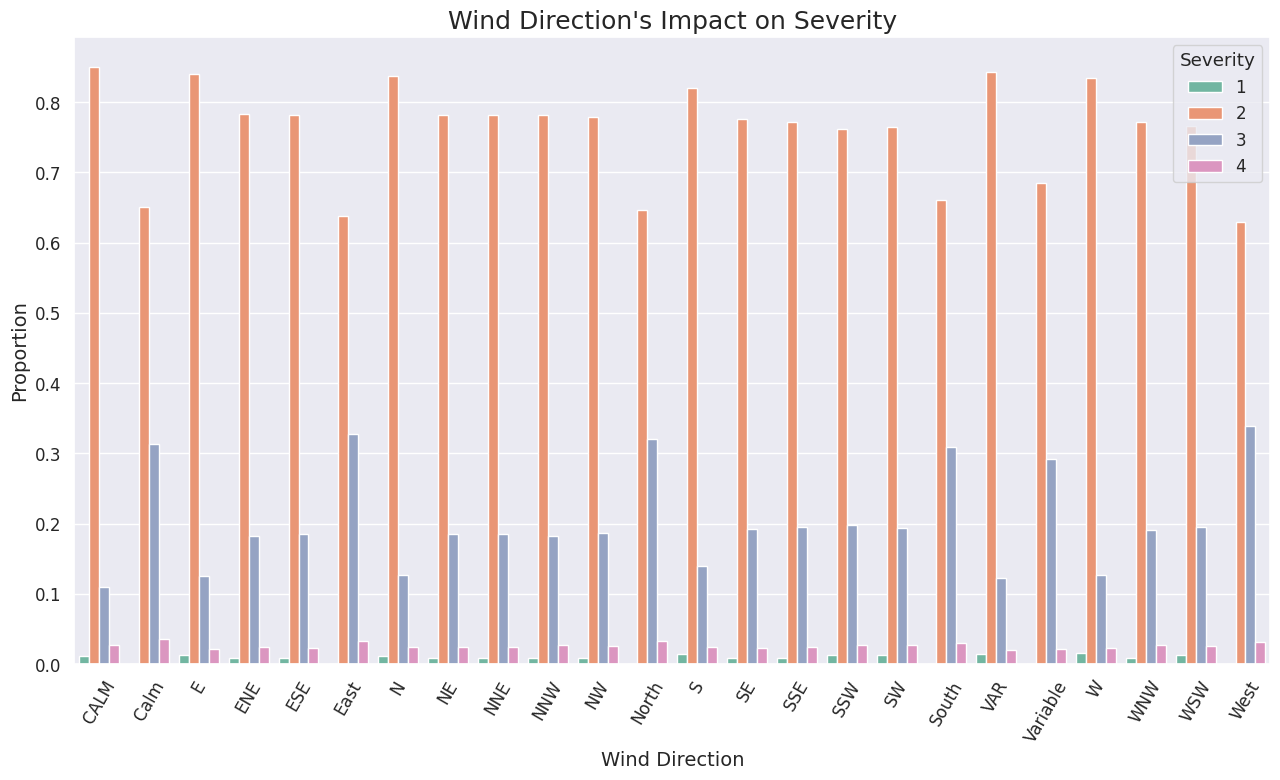

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a proportional dataset for Wind Direction grouped by Severity
wind_data = df.groupby(['Wind_Direction', 'Severity']).size().reset_index(name='Count')
wind_data['Proportion'] = wind_data.groupby('Wind_Direction')['Count'].transform(lambda x: x / x.sum())

# Plot the proportional bar chart
plt.figure(figsize=(13, 8))
sns.barplot(
    data=wind_data,
    x='Wind_Direction',
    y='Proportion',
    hue='Severity',
    palette='Set2'
)

# Customize the plot
plt.xlabel("Wind Direction", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title("Wind Direction's Impact on Severity", fontsize=18)
plt.xticks(rotation=60)  # Rotate x-axis labels
plt.tight_layout()

# Display the plot
plt.show()


The chart shows the proportion of accident severity levels for various wind directions. Severity level **2** consistently dominates across all wind directions, while other severity levels show relatively minor variations. There appears to be no significant correlation between wind direction and accident severity, as the distribution remains largely uniform regardless of the wind direction. This suggests that wind direction may not be a strong factor influencing accident severity.

### **5.10 Number of Accidents per State**


In [37]:
state_counts = df["State"].value_counts()
fig = go.Figure(data=go.Choropleth(locations=state_counts.index, z=state_counts.values.astype(float), locationmode="USA-states", colorscale="turbo"))
fig.update_layout(title_text="Number of US Accidents for each State", geo_scope="usa")
fig.show()

### **5.10 Most Frequent Road Features**


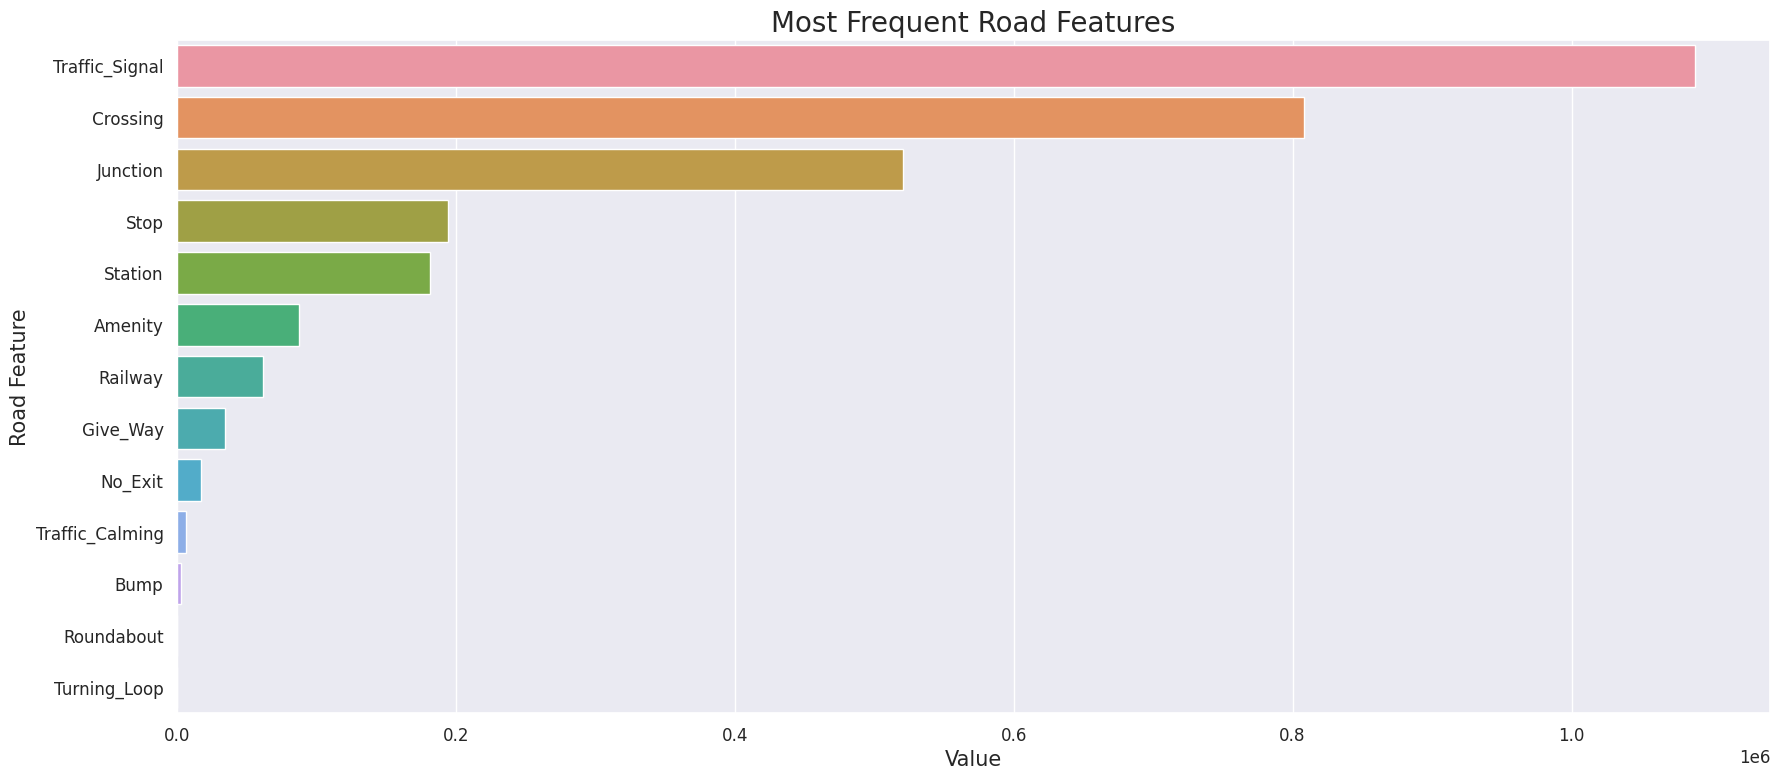

In [40]:
road_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", 
                 "No_Exit", "Railway", "Roundabout", "Station", "Stop", 
                 "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]

# Sum and sort road feature data
data = df[road_features].sum().sort_values(ascending=False)

# Plot the barplot
plt.figure(figsize=(18, 8))
plt.title("Most Frequent Road Features", fontsize=20)
sns.barplot(x=data.values, y=data.index, orient="h")  # Pass x and y explicitly
plt.xlabel("Value", fontsize=15)
plt.ylabel("Road Feature", fontsize=15)
plt.tight_layout()
plt.show()

## **6. Data Preprocessing**
Before exploring feature relationships, it's crucial to prepare the data for analysis. This includes ensuring there are no missing values, encoding categorical variables, and standardizing numerical features if necessary.



In [28]:
X = df
X.head()


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,City,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,Dayton,...,False,False,Night,Night,Night,Night,2016,2,8,5
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Reynoldsburg,...,False,False,Night,Night,Night,Day,2016,2,8,6
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,Williamsburg,...,True,False,Night,Night,Day,Day,2016,2,8,6
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,Dayton,...,False,False,Night,Day,Day,Day,2016,2,8,7
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Dayton,...,True,False,Day,Day,Day,Day,2016,2,8,7


### **6.1 Check Correlation Between Features**

Correlation analysis helps us understand relationships between numerical features in the dataset. This can be particularly useful for feature selection and multicollinearity checks.


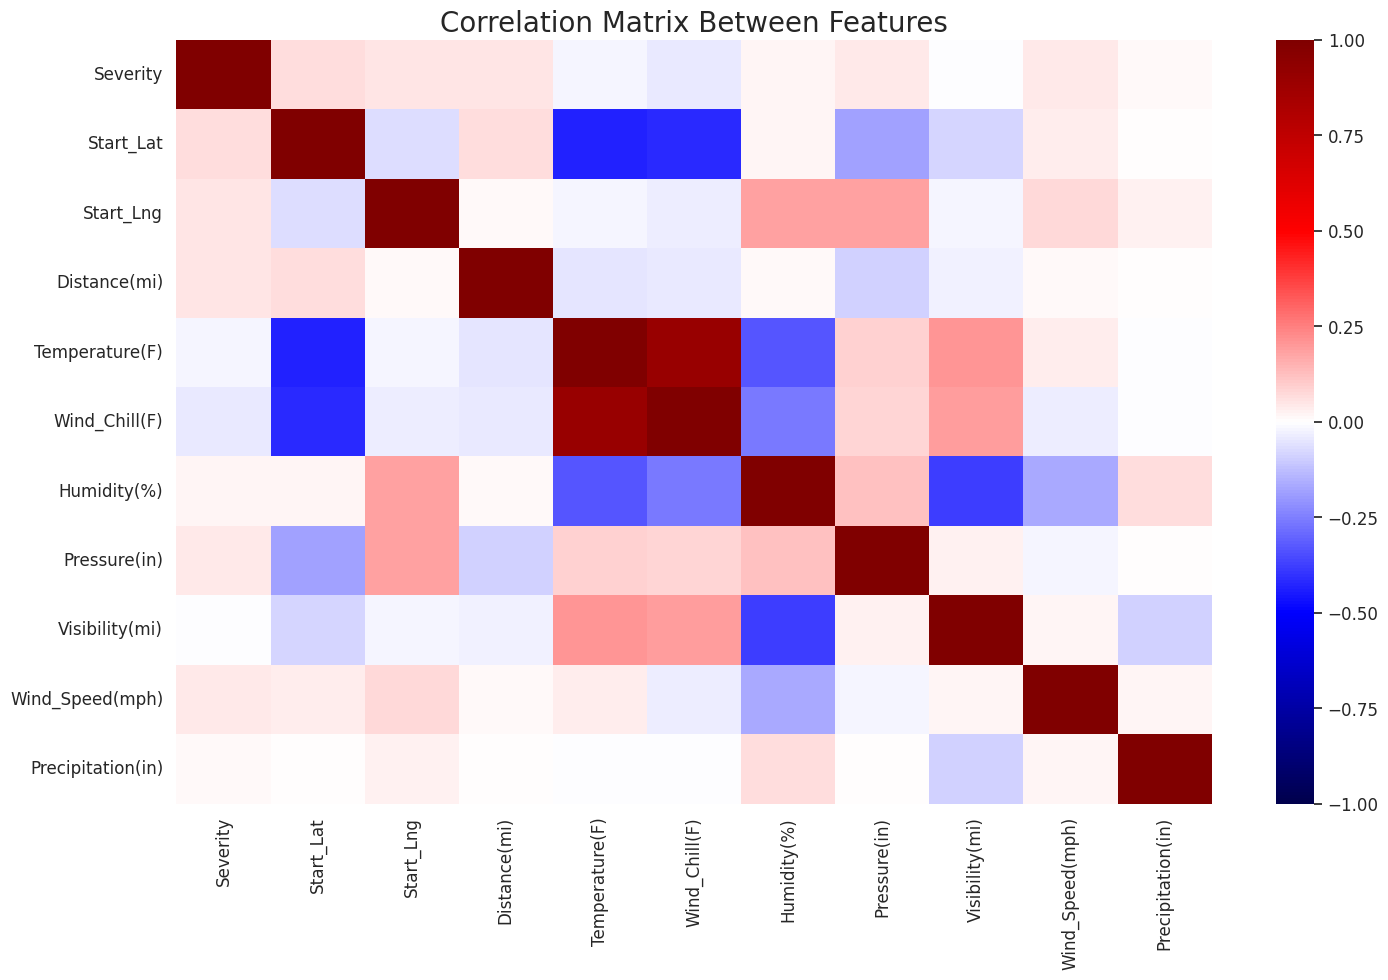

In [38]:
# Select only numeric columns for correlation computation
numeric_columns = X.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic")

# Add hatch and edge color to the plot background
plt.gca().patch.set(hatch="X", edgecolor="#666")

# Display the plot
plt.title('Correlation Matrix Between Features', size=20)
plt.tight_layout()
plt.show()